## <font color="#CA3532"> **Librerias**

In [2]:
import numpy as np
import pandas as pd

from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, GRU
from keras.callbacks import ModelCheckpoint

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score as R2_score

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

import os 

import joblib


2023-12-03 20:50:07.227907: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-03 20:50:07.280793: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-03 20:50:07.281492: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-03 20:50:08.334128: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## <font color="#CA3532"> **Carga de datos**

In [3]:
data = pd.read_csv(os.path.join(os.getcwd(), "data", "commodities.csv"), parse_dates=["date"])
data.head(-20)

date     gold   copper   coffee   silver
0    2015-01-02  1181.10  2.82100  163.725  15.7850
1    2015-01-03  1181.10  2.82100  163.725  15.7850
2    2015-01-04  1181.10  2.82100  163.725  15.7850
3    2015-01-05  1192.65  2.78550  164.375  15.9450
4    2015-01-06  1212.45  2.76925  171.725  16.4275
...         ...      ...      ...      ...      ...
3200 2023-10-07  1836.25  3.59825  145.625  21.3600
3201 2023-10-08  1836.25  3.59825  145.625  21.3600
3202 2023-10-09  1867.40  3.64325  146.350  21.9425
3203 2023-10-10  1872.60  3.63275  146.050  21.9425
3204 2023-10-11  1881.30  3.63125  147.750  22.1150

[3205 rows x 5 columns]

In [4]:
data = data.set_index('date')

In [5]:
def grafica_entrenamiento(tr_mse, val_mse):
    ax=plt.figure(figsize=(10,4)).gca()
    plt.plot(1+np.arange(len(tr_mse)), tr_mse)
    plt.plot(1+np.arange(len(val_mse)), val_mse)
    plt.title('mse del modelo', fontsize=18)
    plt.xlabel('epoca', fontsize=18)
    plt.ylabel('mse', fontsize=18)
    plt.legend(['entrenamiento', 'validación'], loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.show()
    
def train_val_test_split(dataframe, tr_size=0.8, vl_size=0.1, ts_size=0.1 ):
    # Definir número de datos en cada subserie
    N = dataframe.shape[0]
    Ntrain = int(tr_size*N)  # Número de datos de entrenamiento
    Nval = int(vl_size*N)    # Número de datos de validación
    Ntst = N - Ntrain - Nval # Número de datos de prueba

    # Realizar partición
    train = dataframe[0:Ntrain]
    val = dataframe[Ntrain:Ntrain+Nval]
    test = dataframe[Ntrain+Nval:]

    return train, val, test
    
def crear_dataset_supervisado(array, input_length, output_length):
    '''Permite crear un dataset con las entradas (X) y salidas (Y)
    requeridas por la Red LSTM.

    Parámetros:
    - array: arreglo numpy de tamaño N x features (N: cantidad de datos,
      f: cantidad de features)
    - input_length: instantes de tiempo consecutivos de la(s) serie(s) de tiempo
      usados para alimentar el modelo
    - output_length: instantes de tiempo a pronosticar (salida del modelo)
    '''

    # Inicialización
    X, Y = [], []    # Listados que contendrán los datos de entrada y salida del modelo
    shape = array.shape
    if len(shape)==1: # Si tenemos sólo una serie (univariado)
        fils, cols = array.shape[0], 1
        array = array.reshape(fils,cols)
    else: # Multivariado <-- <--- ¡esta parte de la función se ejecuta en este caso!
        fils, cols = array.shape

    # Generar los arreglos
    for i in range(fils-input_length-output_length):
        X.append(array[i:i+INPUT_LENGTH,0:cols])
        Y.append(array[i+input_length:i+input_length+output_length,0].reshape(output_length,1))
    
    # Convertir listas a arreglos de NumPy
    X = np.array(X)
    Y = np.array(Y)
    
    return X, Y

def escalar_dataset(data_input, col_ref):
    '''Escala el dataset en el rango de -1 a 1.

    Entradas:
    - data_input: diccionario con los dataset de entrada y salida del modelo
    (data_input = {'x_tr':x_tr, 'y_tr':y_tr, 'x_vl':x_vl, 'y_vl':y_vl,
                    'y_ts':y_ts})
    - col_ref: parámetro adicional para especificar la columna que contiene
      la variable a predecir

    
    Retorna:
    - data_scaled: diccionario con los datasets de entrada y salida escalados
      (tiene la misma estructura del diccionario de entrada)
    - scaler: el escalador usado (requerido para las predicciones)
    '''

    # *** Implementación adicional: determinar el índice de la columna
    # que contiene la variable a predecir
    col_ref = data.columns.get_loc(col_ref)


    # Número de instantes de tiempo de entrada y de covariables
    NSAMPLES = data_input['x_tr'].shape[1]
    NFEATS = data_input['x_tr'].shape[2]

    # Generar listado con "scalers" (1 por cada covariable de entrada)
    scalers = [MinMaxScaler(feature_range=(-1,1)) for i in range(NFEATS)]

    # Arreglos que contendrán los datasets escalados
    x_tr_s = np.zeros(data_input['x_tr'].shape)
    x_vl_s = np.zeros(data_input['x_vl'].shape)
    x_ts_s = np.zeros(data_input['x_ts'].shape)
    y_tr_s = np.zeros(data_input['y_tr'].shape)
    y_vl_s = np.zeros(data_input['y_vl'].shape)
    y_ts_s = np.zeros(data_input['y_ts'].shape)

    # Escalamiento: se usarán los min/max del set de entrenamiento para
    # escalar la totalidad de los datasets

    # Escalamiento Xs
    for i in range(NFEATS):
        x_tr_s[:,:,i] = scalers[i].fit_transform(x_tr[:,:,i])
        x_vl_s[:,:,i] = scalers[i].transform(x_vl[:,:,i])
        x_ts_s[:,:,i] = scalers[i].transform(x_ts[:,:,i])
    
    # Escalamiento Ys (teniendo en cuenta "col_ind")
    y_tr_s[:,:,0] = scalers[col_ref].fit_transform(y_tr[:,:,0])
    y_vl_s[:,:,0] = scalers[col_ref].transform(y_vl[:,:,0])
    y_ts_s[:,:,0] = scalers[col_ref].transform(y_ts[:,:,0])

    # Conformar diccionario de salida
    data_scaled = {
        'x_tr_s': x_tr_s, 'y_tr_s': y_tr_s,
        'x_vl_s': x_vl_s, 'y_vl_s': y_vl_s,
        'x_ts_s': x_ts_s, 'y_ts_s': y_ts_s,
    }

    return data_scaled, scalers[col_ref]

def get_data_for_model(INPUT_LENGTH, OUTPUT_LENGTH):
    x_tr, y_tr = crear_dataset_supervisado(tr.values, INPUT_LENGTH, OUTPUT_LENGTH)
    x_vl, y_vl = crear_dataset_supervisado(vl.values, INPUT_LENGTH, OUTPUT_LENGTH)
    x_ts, y_ts = crear_dataset_supervisado(ts.values, INPUT_LENGTH, OUTPUT_LENGTH)

    # Imprimir información en pantalla
    print('Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)')
    print(f'Set de entrenamiento - x_tr: {x_tr.shape}, y_tr: {y_tr.shape}')
    print(f'Set de validación - x_vl: {x_vl.shape}, y_vl: {y_vl.shape}')
    print(f'Set de prueba - x_ts: {x_ts.shape}, y_ts: {y_ts.shape}')
    
    return x_tr, y_tr, x_vl, y_vl, x_ts, y_ts

def escaler_all_data(x_tr, y_tr, x_vl, y_vl, x_ts, y_ts):
    # Escalamiento del dataset con la función anterior

    # Crear diccionario de entrada
    data_in = {
        'x_tr': x_tr, 'y_tr': y_tr,
        'x_vl': x_vl, 'y_vl': y_vl,
        'x_ts': x_ts, 'y_ts': y_ts,
    }

    # Y escalar (especificando la columna con la variable a predecir)
    data_s, scaler = escalar_dataset(data_in, col_ref = 'gold' )

    # Extraer subsets escalados
    x_tr_s, y_tr_s = data_s['x_tr_s'], data_s['y_tr_s']
    x_vl_s, y_vl_s = data_s['x_vl_s'], data_s['y_vl_s']
    x_ts_s, y_ts_s = data_s['x_ts_s'], data_s['y_ts_s']
    
    return data_in, x_tr_s, y_tr_s,  x_vl_s, y_vl_s, x_ts_s, y_ts_s, data_s, scaler

### <font color="#CA3532"> **Dividir los datos en conjutnos de entrenamiento, validación y prueba**

In [6]:
# Prueba de la función
tr, vl, ts = train_val_test_split(data)

print(f'Tamaño set de entrenamiento: {tr.shape}')
print(f'Tamaño set de validación: {vl.shape}')
print(f'Tamaño set de prueba: {ts.shape}')

Tamaño set de entrenamiento: (2580, 4)
Tamaño set de validación: (322, 4)
Tamaño set de prueba: (323, 4)


### <font color="#CA3532"> **Visualizar serie temporal**

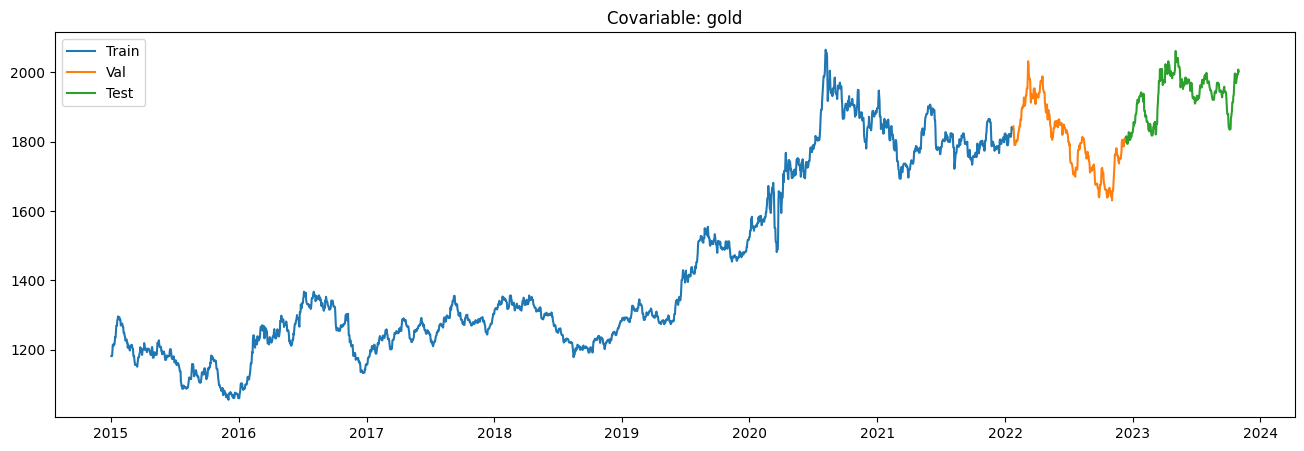

In [7]:
col = data.columns[0]

# Dibujar los sets de entrenamiento/validación/prueba para la covariable
fig, ax = plt.subplots(figsize = (16,5))
ax.plot(tr[col], label='Train')
ax.plot(vl[col], label='Val')
ax.plot(ts[col], label='Test')
ax.set_title(f'Covariable: {col}')
plt.legend();

### <font color="#CA3532"> **Generación del dataset supervisado (entrada y salida del modelo)**

En este caso, con relación al modelo multivariado-multistep, cambiaremos el tamaño del dato de salida pues ahora se generarán 7 días de predicciones consecutivas.

![](https://drive.google.com/uc?export=view&id=1SgWsPot-pAB0upTCSwWoY-KDnJFNMD3A)

In [10]:
# Crear los datasets de entrenamiento, prueba y validación y verificar sus tamaños
INPUT_LENGTH = 60    # Hiperparámetro
OUTPUT_LENGTH = 30   # Modelo multi-step

x_tr, y_tr, x_vl, y_vl, x_ts, y_ts = get_data_for_model(INPUT_LENGTH, OUTPUT_LENGTH)

Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)
Set de entrenamiento - x_tr: (2490, 60, 4), y_tr: (2490, 30, 1)
Set de validación - x_vl: (232, 60, 4), y_vl: (232, 30, 1)
Set de prueba - x_ts: (233, 60, 4), y_ts: (233, 30, 1)


### <font color="#CA3532"> **Escalamiento**

Es requerido para garantizar que todas las características se encuentran en el mismo rango de valores, lo que facilita el entrenamiento del modelo y las predicciones.

In [11]:
data_in, x_tr_s, y_tr_s,  x_vl_s, y_vl_s, x_ts_s, y_ts_s, data_s, scaler = escaler_all_data(x_tr, y_tr, x_vl, y_vl, x_ts, y_ts)

DatetimeIndex(['2015-01-02', '2015-01-03', '2015-01-04', '2015-01-05',
               '2015-01-06', '2015-01-07', '2015-01-08', '2015-01-09',
               '2015-01-10', '2015-01-11',
               ...
               '2022-01-15', '2022-01-16', '2022-01-17', '2022-01-18',
               '2022-01-19', '2022-01-20', '2022-01-21', '2022-01-22',
               '2022-01-23', '2022-01-24'],
              dtype='datetime64[ns]', name='date', length=2580, freq=None)

In [141]:
# np.save('date_tr.npy', tr.index) 
# np.save('date_vl.npy', vl.index) 
# np.save('date_ts.npy', ts.index) 

In [142]:
# np.save('x_tr_s_thirty.npy', x_tr_s) 
# np.save('x_vl_s_thirty.npy', x_vl_s) 
# np.save('x_ts_s_thirty.npy', x_ts_s) 

# np.save('y_tr_s_thirty.npy', y_tr_s) 
# np.save('y_vl_s_thirty.npy', y_vl_s) 
# np.save('y_ts_s_thirty.npy', y_ts_s) 

# joblib.dump(scaler, 'scaler_thirty.pkl')

In [12]:
# Creación del modelo
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import RMSprop, Adam
import tensorflow as tf

### <font color="#CA3532"> **Arquitectura para el modelo SEVEN**

In [94]:


# Ajustar parámetros para reproducibilidad del entrenamiento
tf.random.set_seed(123)
tf.config.experimental.enable_op_determinism()


N_UNITS = 600
INPUT_SHAPE = (x_tr_s.shape[1], x_tr_s.shape[2])  # Asegúrate de definir x_tr_s antes de esta línea

model = Sequential()
model.add(LSTM(N_UNITS, input_shape=INPUT_SHAPE))
model.add(Dropout(rate=0.35))
model.add(Dense(units=60, activation='relu'))
model.add(Dense(units=120, activation='relu'))
model.add(Dropout(rate=0.25))  # Añadido para coincidir con tu summary

# Y lo único que cambia con respecto al modelo multivariado + multi-step es
# el tamaño deldato de salida (4 horas)
model.add(Dense(OUTPUT_LENGTH, activation='linear')) # activation = 'linear' pues queremos pronosticar (regresión)

# Compilación
optimizador = RMSprop(learning_rate=5e-4) # 5e-5
model.compile(
    optimizer = optimizador,
    loss = "mse",
)

modelpath = os.path.join(os.getcwd(), "models", "sevenModel.h5") # fichero en el que guardaré el mejor modelo
checkpoint = ModelCheckpoint(modelpath, monitor="val_loss", verbose=2, save_best_only=True, mode='min')

# Entrenamiento (aproximadamente 1 min usando GPU)
EPOCHS = 300 # Hiperparámetro
BATCH_SIZE = 120 # Hiperparámetro
historia = model.fit(
    x = x_tr_s,
    y = y_tr_s,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    validation_data = (x_vl_s, y_vl_s),
    verbose=2,
    callbacks=[checkpoint]
)

2023-11-20 00:00:52.776409: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-20 00:00:52.778158: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-20 00:00:52.779434: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

### <font color="#CA3532"> **Arquitectura para el modelo FIFTEEN**


In [144]:


# Ajustar parámetros para reproducibilidad del entrenamiento
tf.random.set_seed(123)
tf.config.experimental.enable_op_determinism()


N_UNITS = 800
INPUT_SHAPE = (x_tr_s.shape[1], x_tr_s.shape[2])  # Asegúrate de definir x_tr_s antes de esta línea

model = Sequential()
model.add(LSTM(N_UNITS, input_shape=INPUT_SHAPE))
model.add(Dropout(rate=0.45))
model.add(Dense(units=60, activation='relu'))
model.add(Dense(units=120, activation='relu'))
model.add(Dense(units=140, activation='relu'))
model.add(Dropout(rate=0.35))  # Añadido para coincidir con tu summary

# Y lo único que cambia con respecto al modelo multivariado + multi-step es
# el tamaño deldato de salida (4 horas)
model.add(Dense(OUTPUT_LENGTH, activation='linear')) # activation = 'linear' pues queremos pronosticar (regresión)

# Compilación
optimizador = RMSprop(learning_rate=5e-4) # 5e-5
model.compile(
    optimizer = optimizador,
    loss = "mse",
)

modelpath = os.path.join(os.getcwd(), "models", "fifteenModel.h5") # fichero en el que guardaré el mejor modelo
checkpoint = ModelCheckpoint(modelpath, monitor="val_loss", verbose=2, save_best_only=True, mode='min')

# Entrenamiento (aproximadamente 1 min usando GPU)
EPOCHS = 200 # Hiperparámetro
BATCH_SIZE = 140 # Hiperparámetro
historia = model.fit(
    x = x_tr_s,
    y = y_tr_s,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    validation_data = (x_vl_s, y_vl_s),
    verbose=2,
    callbacks=[checkpoint]
)

Epoch 1/200


2023-11-20 00:51:24.500760: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-20 00:51:24.502398: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-20 00:51:24.503679: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus


Epoch 1: val_loss improved from inf to 0.08551, saving model to /media/jhonnyrv/20F40883F4085E02/ModelActual/ModelOro/abyModel/AbyModel/ModelTrainning/models/fifteenModel.h5
19/19 - 8s - loss: 0.1963 - val_loss: 0.0855 - 8s/epoch - 406ms/step
Epoch 2/200

Epoch 2: val_loss improved from 0.08551 to 0.03188, saving model to /media/jhonnyrv/20F40883F4085E02/ModelActual/ModelOro/abyModel/AbyModel/ModelTrainning/models/fifteenModel.h5
19/19 - 4s - loss: 0.0604 - val_loss: 0.0319 - 4s/epoch - 232ms/step
Epoch 3/200

Epoch 3: val_loss did not improve from 0.03188
19/19 - 4s - loss: 0.0478 - val_loss: 0.0340 - 4s/epoch - 197ms/step
Epoch 4/200

Epoch 4: val_loss improved from 0.03188 to 0.01845, saving model to /media/jhonnyrv/20F40883F4085E02/ModelActual/ModelOro/abyModel/AbyModel/ModelTrainning/models/fifteenModel.h5
19/19 - 4s - loss: 0.0388 - val_loss: 0.0184 - 4s/epoch - 220ms/step
Epoch 5/200

Epoch 5: val_loss did not improve from 0.01845
19/19 - 4s - loss: 0.0352 - val_loss: 0.0200 - 

### <font color="#CA3532"> **Arquitectura para el modelo THIRTY**


In [13]:


# Ajustar parámetros para reproducibilidad del entrenamiento
tf.random.set_seed(123)
tf.config.experimental.enable_op_determinism()


N_UNITS = 1300
INPUT_SHAPE = (x_tr_s.shape[1], x_tr_s.shape[2])  # Asegúrate de definir x_tr_s antes de esta línea

model = Sequential()
model.add(LSTM(N_UNITS, input_shape=INPUT_SHAPE))
model.add(Dropout(rate=0.60))
model.add(Dense(units=60, activation='relu'))
model.add(Dense(units=120, activation='relu'))
model.add(Dense(units=140, activation='relu'))
model.add(Dense(units=160, activation='relu'))
model.add(Dense(units=180, activation='relu'))
model.add(Dropout(rate=0.50))  # Añadido para coincidir con tu summary

# Y lo único que cambia con respecto al modelo multivariado + multi-step es
# el tamaño deldato de salida (4 horas)
model.add(Dense(OUTPUT_LENGTH, activation='linear')) # activation = 'linear' pues queremos pronosticar (regresión)

# Compilación
optimizador = RMSprop(learning_rate=5e-4) # 5e-5
model.compile(
    optimizer = optimizador,
    loss = "mse",
)

modelpath = os.path.join(os.getcwd(), "models", "thirtyModel.h5") # fichero en el que guardaré el mejor modelo
checkpoint = ModelCheckpoint(modelpath, monitor="val_loss", verbose=2, save_best_only=True, mode='min')

# Entrenamiento (aproximadamente 1 min usando GPU)
EPOCHS = 50 # Hiperparámetro
BATCH_SIZE = 180 # Hiperparámetro
historia = model.fit(
    x = x_tr_s,
    y = y_tr_s,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    validation_data = (x_vl_s, y_vl_s),
    verbose=2,
    callbacks=[checkpoint]
)

2023-11-20 13:25:37.928674: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-20 13:25:37.929626: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-11-20 13:25:40.197167: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gra

Epoch 1/50


2023-11-20 13:25:40.669405: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-20 13:25:40.671264: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-20 13:25:40.672719: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus


Epoch 1: val_loss improved from inf to 0.22071, saving model to /media/jhonnyrv/20F40883F4085E02/ModelActual/ModelOro/abyModel/AbyModel/ModelTrainning/models/thirtyModel.h5
14/14 - 32s - loss: 0.2708 - val_loss: 0.2207 - 32s/epoch - 2s/step
Epoch 2/50

Epoch 2: val_loss improved from 0.22071 to 0.18016, saving model to /media/jhonnyrv/20F40883F4085E02/ModelActual/ModelOro/abyModel/AbyModel/ModelTrainning/models/thirtyModel.h5
14/14 - 29s - loss: 0.1642 - val_loss: 0.1802 - 29s/epoch - 2s/step
Epoch 3/50

Epoch 3: val_loss improved from 0.18016 to 0.06604, saving model to /media/jhonnyrv/20F40883F4085E02/ModelActual/ModelOro/abyModel/AbyModel/ModelTrainning/models/thirtyModel.h5
14/14 - 29s - loss: 0.1023 - val_loss: 0.0660 - 29s/epoch - 2s/step
Epoch 4/50

Epoch 4: val_loss improved from 0.06604 to 0.04303, saving model to /media/jhonnyrv/20F40883F4085E02/ModelActual/ModelOro/abyModel/AbyModel/ModelTrainning/models/thirtyModel.h5
14/14 - 29s - loss: 0.0701 - val_loss: 0.0430 - 29s/epo

### <font color="#CA3532"> **Gráfico de entrenamiento**


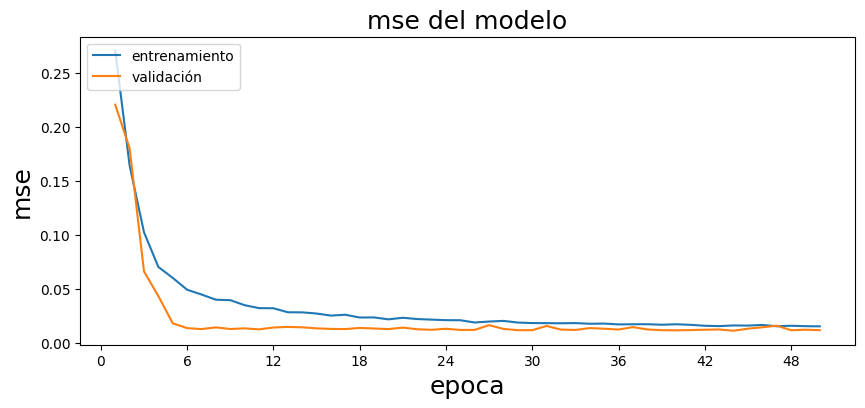

In [14]:
grafica_entrenamiento(historia.history['loss'], historia.history['val_loss'])

### <font color="#CA3532"> **Desempeño del modelo**

Suponiendo que el modelo ya ha sido afinado y entrenado, verificaremos su desempeño para el set de prueba y lo compararemos con el desempeño obtenido con los sets de entrenamiento y validación:

In [15]:
# Cálculo de rmses para train, val y test
rmse_tr = model.evaluate(x=x_tr_s, y=y_tr_s, verbose=0)
rmse_vl = model.evaluate(x=x_vl_s, y=y_vl_s, verbose=0)
rmse_ts = model.evaluate(x=x_ts_s, y=y_ts_s, verbose=0)

# Imprimir resultados en pantalla
print('Comparativo desempeños:')
print(f'  MSE train:\t {rmse_tr:.5f}')
print(f'  MSE val:\t {rmse_vl:.5f}')
print(f'  MSE test:\t {rmse_ts:.5f}')

2023-11-20 13:51:56.700423: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [2490,30,1]
	 [[{{node Placeholder/_11}}]]
2023-11-20 13:51:56.700839: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [2490,30,1]
	 [[{{node Placeholder/_11}}]]
2023-11-20 13:52:12.657476: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and

Comparativo desempeños:
  MSE train:	 0.00671
  MSE val:	 0.01152
  MSE test:	 0.01457


### <font color="#CA3532"> **Predicciones**

In [16]:
def predecir(x, model, scaler):
    '''Genera la predicción de OUTPUT_LENGTH instantes
    de tiempo a futuro con el modelo entrenado.

    Entrada:
    - x: batch (o batches) de datos para ingresar al modelo
      (tamaño: BATCHES X INPUT_LENGTH X FEATURES)
    - model: Red LSTM entrenada
    - scaler: escalador (requerido para llevar la predicción a la escala original)
    
    Salida:
    - y_pred: la predicción en la escala original (tamaño: BATCHES X OUTPUT_LENGTH X FEATURES)
    '''

    # Calcular predicción escalada en el rango de -1 a 1
    y_pred_s = model.predict(x,verbose=0)

    # Llevar la predicción a la escala original
    y_pred = scaler.inverse_transform(y_pred_s)

    return y_pred

In [17]:
# Calcular predicciones sobre el set de prueba
y_ts_pred = predecir(x_ts_s, model, scaler)

# Calcular predicciones sobre el set de prueba
y_vl_pred = predecir(x_vl_s, model, scaler)

# Calcular predicciones sobre el set de prueba
y_tr_pred = predecir(x_tr_s, model, scaler)

2023-11-20 13:52:42.670379: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [233,60,4]
	 [[{{node Placeholder/_10}}]]
2023-11-20 13:52:42.670658: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [233,60,4]
	 [[{{node Placeholder/_10}}]]
2023-11-20 13:52:42.927577: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/s

### <font color="#CA3532"> **Gráfico de errores**

In [18]:
y_ts[:y_vl_pred.shape[0]].shape

(232, 30, 1)

In [19]:
y_ts_pred[:y_vl_pred.shape[0]].shape

(232, 30)

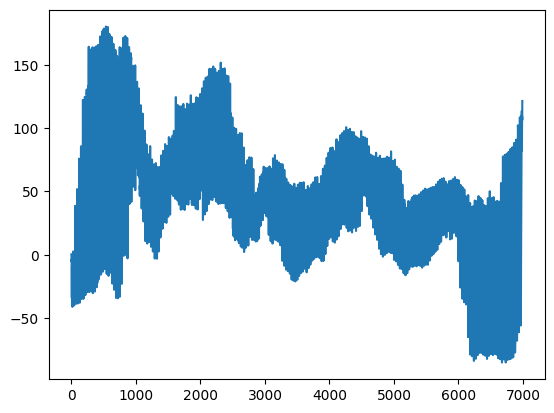

In [20]:
N = len(y_ts_pred)    # Número de predicciones
ndato = np.linspace(1,N,N)

# Cálculo de errores simples
errores = y_ts.flatten()-y_ts_pred.flatten()
plt.plot(errores);

In [21]:
# Máscara para errores menores a 0
errores_menores_a_cero = errores[errores < 0]

# Máscara para errores mayores a 0
errores_mayores_a_cero = errores[errores > 0]

# Calculamos los promedios
promedio_errores_menores_a_cero = np.mean(errores_menores_a_cero)
promedio_errores_mayores_a_cero = np.mean(errores_mayores_a_cero)

# Imprimimos los resultados
print(f"   Promedio de errores menores a 0: {promedio_errores_menores_a_cero}")
print(f"   Promedio de errores mayores a 0: {promedio_errores_mayores_a_cero}\n")

   Promedio de errores menores a 0: -28.007659533792282
   Promedio de errores mayores a 0: 53.140548773961626



### <font color="#CA3532"> **Gráfico: Valores reales vs valores predichos (Entrenamiento, validación y prueba)**

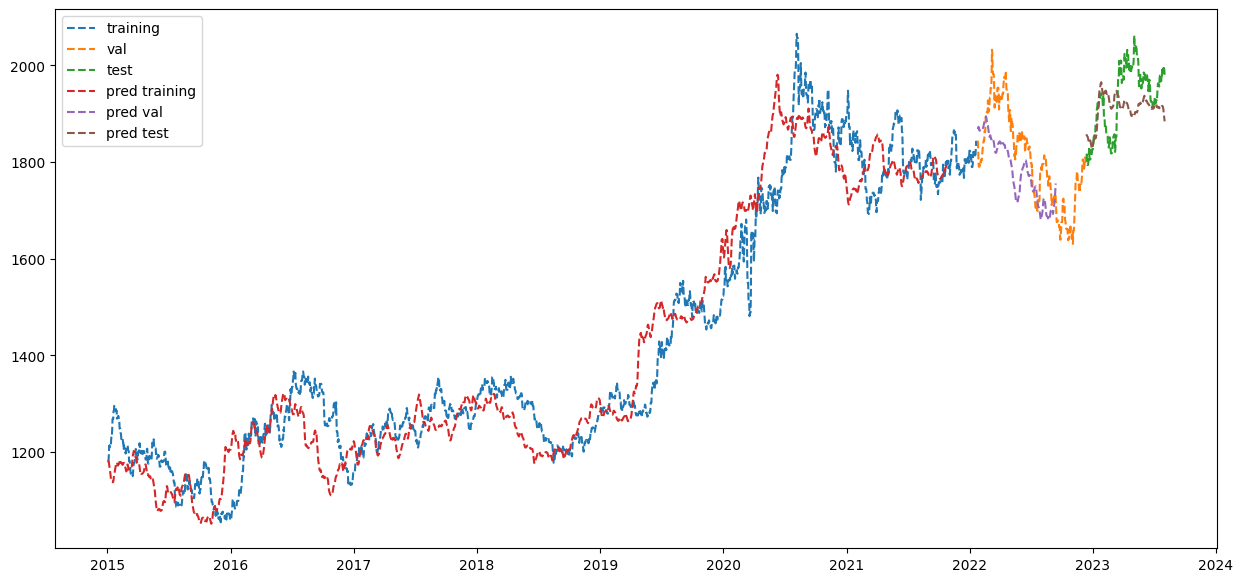

In [22]:
plt.figure(figsize=(15,7))
plt.plot(tr.index, tr.gold.values, '--', label="training")
plt.plot(vl.index, vl.gold.values, '--', label="val")
plt.plot(ts.index[:y_ts_pred.shape[0]], ts.gold.values[:y_ts_pred.shape[0]], '--', label="test")
plt.plot(tr.index[:y_tr_pred.shape[0]], y_tr_pred[:, 0], '--', label="pred training")
plt.plot(vl.index[:y_vl_pred.shape[0]], y_vl_pred[:, 0], '--', label="pred val")
plt.plot(ts.index[:y_ts_pred.shape[0]], y_ts_pred[:, 0], '--', label="pred test")
plt.legend();

### <font color="#CA3532"> **Gráfico: Valores reales vs valores predichos (prueba)**

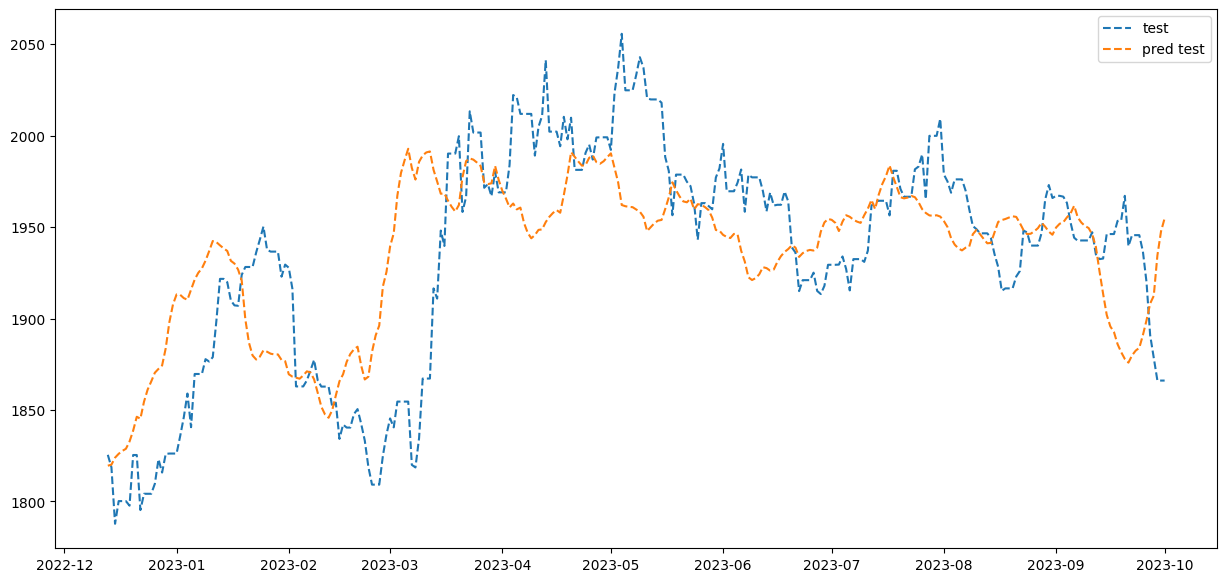

In [154]:
plt.figure(figsize=(15,7))
plt.plot(ts.index[:y_ts_pred.shape[0]], ts.gold.values[:y_ts_pred.shape[0]], '--', label="test")
plt.plot(ts.index[:y_ts_pred.shape[0]], y_ts_pred[:, 0], '--', label="pred test")
plt.legend();

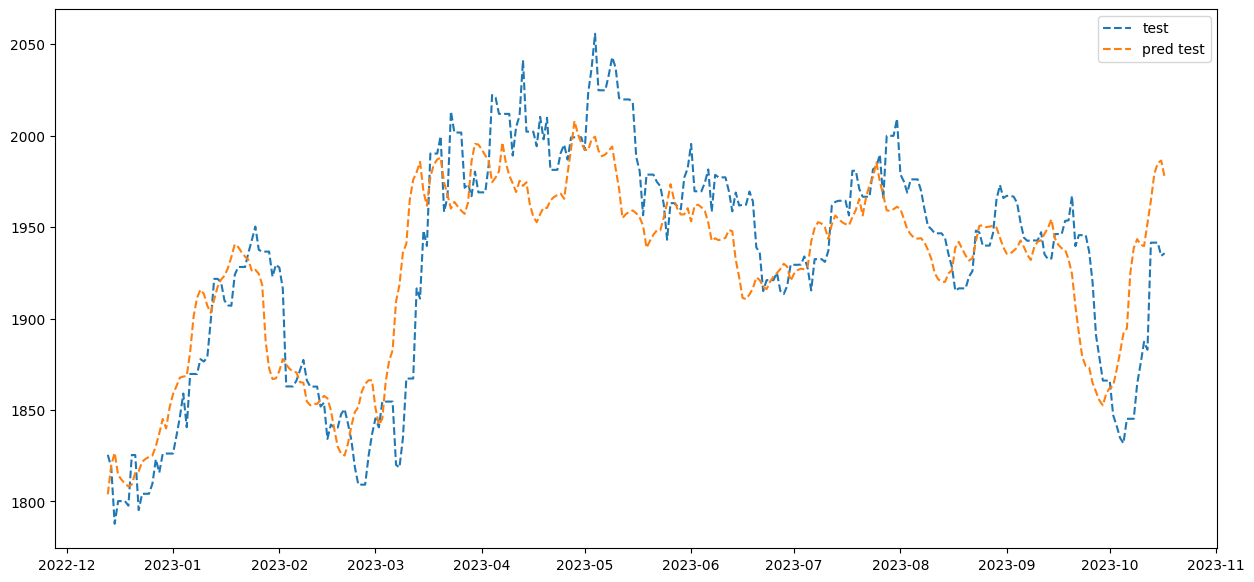

In [39]:
plt.figure(figsize=(15,7))
plt.plot(ts.index[:y_ts_pred.shape[0]], ts.gold.values[:y_ts_pred.shape[0]], '--', label="test")
plt.plot(ts.index[:y_ts_pred.shape[0]], y_ts_pred[:, 0], '--', label="pred test")
plt.legend();